# CLUSTERING PRODDUCTS
## Using NPL and K-Means clustering



---



### Load libraries

In [1]:
'''
!pip install fuzzywuzzy
!pip install plotly
!pip install gensim
!pip install webcolors
'''

'\n!pip install fuzzywuzzy\n!pip install plotly\n!pip install gensim\n!pip install webcolors\n'

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



### Data load

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/DataScienceProjectTeam/data.csv', encoding="ISO-8859-2", dtype={'CustomerID': str,'InvoiceNo': str}, engine='python')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


### Data preprocessing

Only the **Description** column is needed for this analysis.

Removing stopwords, punctuation and numbers that are the common words in language like ‘the’, ‘a’, ‘is’, ‘and’ using Gensim library and Python string library

In [6]:
df = df.dropna()
df = df.drop_duplicates()
text1_df = df[['Description']]
text1 = df['Description']


#text1_rest_df, text1_small_df = train_test_split(text1_df, test_size=0.9, random_state=25)
#text1_rest, text1_small = train_test_split(text1, test_size=0.9, random_state=25)


text1_small_df = text1_df.drop_duplicates()
text1_small = text1.drop_duplicates()

text2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in text1_small]

Shortenning words (Stemming) which trasnforms words to their root form. Eg. ‘apple’ and ‘apples’ both become ‘appl.
The Stemming is done using NLTK library.

In [7]:
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

In [8]:
text3 = pd.Series([stemSentence(x) for x in text2])

In [9]:
text3

0        white hang heart tlight holder
1                   white metal lantern
2         cream cupid heart coat hanger
3       knit union flag hot water bottl
4          red woolli hotti white heart
                     ...               
3891            letter W bling key ring
3892            letter Z bling key ring
3893     pink crystal skull phone charm
3894     cream hang heart tlight holder
3895            paper craft littl birdi
Length: 3896, dtype: object

Removing false clustering words.
Words like colours, materials, number, adverbs, adjectives and brand names could make many clusters that falsely describe the content of a cluster.

In [10]:
colors = list(webcolors.CSS3_NAMES_TO_HEX)
colors = [stemSentence(x) for x in colors if x not in ('chocolate','honeydew','lime','olive','orange','plum','salmon','tomato','wheat')]
not_ok_words = ['set', 'glass' , 'silver' , 'pack' , 'box' , 'chocolate' , 'set\\' , 'piece' , 'big' , 'small' , 'large' , 'a' , 'and', 'the'  ,
                "regency" , 'from' , 'no' , 'pack/12' , 'set/5' , '12', 'wooden' , 'in', 'home',  'one' ,'two' , 'three' , 'four' , 'five' , 'six' , 'seven' , 'eight' , 'nine' , 'ten' , ',' , '"j"' , 'yellow/pink' ,  'silver/crystal' , 'my' ,  "can't" , 'with' , 'IF' , 'L' , 'H' , 'LE' , 'g' , 'NO' , 'your' , 'A' , 'it' , 'No' , 'antique' , 'wooden' , 'wood', 'retrospot' , 'vintage' , 'vintag' , 'new', 'clear' , 'fresh' , 'IS' ,  'CM' , 'retro' , 'S' , 'polkadot', 'round' , 'OF' , 'london' , 'french' , 'english' , 'scandinavian' , 'kit' , 
                'I' ,  '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '16' , '12' , 'danish' , 'pink/white' , 'heart' , 'baroque' , 'set/6' , 'victorian' ,  'ceramic' , 'ivory' , 'crystal+glass' , 
'on' , 'metal' , 'purple' , 'enamel' , 'for' , 'assorted' , 'garland' ,'bird' , 'bundle' , 'mini' , 'natural' , 'hot' , '+' , '&' , 
'black+white' , 'babushka' , 'polished' , 'set/6' , 'set/4' , 'skull' , 'skulls' , '+' , '&' , 'assorted' , 'giant' , 'england' , 'zinc' ,
'50', 'pieces' , 'acrylic' , 's/4' , 'traditional' , 'do' , 'not' , 'sweet' , 'sweetheart' , 'rose',
's/15' , 'lunch' , 'design' , 'diamante' , 'incense' , 'love' , 'billboard' , 'own' , 'murano' , 'thank' , 'you',
'cooper' , 'boudicca' , '60' , '40' , '20' , '200' , 'charlie' , 'lola' , 'style' , '//' , 'paisley'
]

not_ok_words.extend(colors)
not_ok_words_upper =  [each_string.upper() for each_string in not_ok_words]

text4 = [' '.join([x for x in string.split() if x not in not_ok_words]) for string in text3]

In [11]:
# df_l = pd.DataFrame (text4, columns = ['Desc'])
# print(df_l)
# df_l['Desc'].isnull().values.any()

### Vectorisation


We want to turn our cleaned text into numerical data so that we can perform statistical analysis on it. <br>
By creating Bag of words using CountVectorizer from sci-kit learn, a model that counts the occurences of the words in every product. <br>
The result is a matrix containing a feature for each distinct word in the text and the count of each word in a row (or vector) as its numerical values.

In [12]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(text4)

In [13]:
#show matrix
matrix = pd.concat([text1_small,pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())], axis = 1)
matrix.head()

matrix = matrix.dropna()
matrix = matrix.drop_duplicates()
matrix.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Description,abc,abstract,acapulco,account,acryl,address,ade,adult,advent,afghan,age,ahoy,aid,air,airlin,airmail,alarm,album,all,allium,alphabet,alpin,aluminium,am,amber,ameli,amethyst,anemon,angel,angelpink,anim,ant,antiqu,antoienett,antoinett,aperitif,apothecari,appl,apron,...,whitepink,whiter,wick,wicker,wildflow,willi,windchim,windmil,windsock,wine,winki,wire,wireless,wise,wish,witch,wknif,wobbl,women,woodland,wool,woolli,word,work,world,woven,wrap,wreath,wreck,write,wsuck,wsucker,xcm,xma,xxcm,yellowblu,yelloworang,yellowpink,yuletid,zincglass
0,WHITE HANGING HEART T-LIGHT HOLDER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WHITE METAL LANTERN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CREAM CUPID HEARTS COAT HANGER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KNITTED UNION FLAG HOT WATER BOTTLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,RED WOOLLY HOTTIE WHITE HEART.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# The elbow method
# sse={}
# for k in np.arange(100,800,100):
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
#     sse[k] = kmeans.inertia_
# plt.plot(list(sse.keys()),list(sse.values()))
# plt.xlabel('Values for K')
# plt.ylabel('SSE')
# plt.show();

### How manny clusters should be used

Elbom method for 3000 clusters

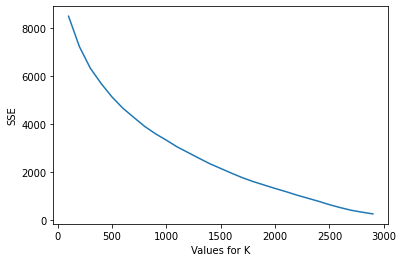

Elbom method for 800 clusters

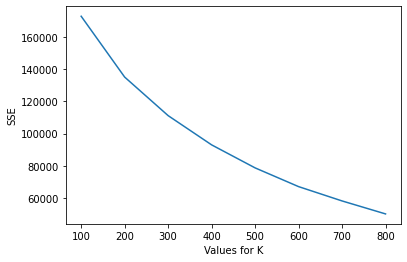

From the elbow method plot it looks like we can use 200, 300 or 400 clusters.

After manny tries and adjusment to the "not ok words", 450 cluster were choosen to be found using KMeans clustering.

### Clustering the products

In [15]:
kmeans = KMeans(n_clusters=450)
kmeans.fit(X_cv)

KMeans(n_clusters=450)

In [16]:
text1_small_df['cluster'] = kmeans.predict(X_cv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
text1_small_df

,Description,cluster
0,WHITE HANGING HEART T-LIGHT HOLDER,256
1,WHITE METAL LANTERN,195
2,CREAM CUPID HEARTS COAT HANGER,96
3,KNITTED UNION FLAG HOT WATER BOTTLE,40
4,RED WOOLLY HOTTIE WHITE HEART.,5
...,...,...
527067,"LETTER ""W"" BLING KEY RING",6
527069,"LETTER ""Z"" BLING KEY RING",6
530382,PINK CRYSTAL SKULL PHONE CHARM,137
537621,CREAM HANGING HEART T-LIGHT HOLDER,256


### Cluster naming


In order to add a more comprehensible meaning of the clusters, a label will be computed by using the most frequently used word (at most 3, if most common words are from the "not ok words" list) in each cluster.

In [18]:


def getMostCommonWords(a_df, not_ok_words_upper):
  ret_val = ''
  tmp_df = a_df
  tmp_counter = tmp_df.Description.str.split(expand=True).stack().value_counts()
  nb_of_word_added = 0
  #print(tmp_counter)

  for i in range(tmp_counter.size):
    #print(tmp_counter.index[i])
    
    if tmp_counter.index[i] not in not_ok_words_upper:
      ret_val += (tmp_counter.index[i] + ' ')
      nb_of_word_added+=1
      #print("test")

      if nb_of_word_added == 2:
        break
      
      
   
  return ret_val

In [19]:
clusters = text1_small_df['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = text1_small_df[text1_small_df['cluster'] == clusters[i]]
    words = getMostCommonWords(subset[['Description']], not_ok_words_upper)
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(text1_small_df,labels_table,on='cluster',how='left')

In [20]:
result_labelled

,Description,cluster,label
0,WHITE HANGING HEART T-LIGHT HOLDER,256,HANGING HOLDER
1,WHITE METAL LANTERN,195,LANTERN HANGING
2,CREAM CUPID HEARTS COAT HANGER,96,CREAM FOOD
3,KNITTED UNION FLAG HOT WATER BOTTLE,40,BOTTLE WATER
4,RED WOOLLY HOTTIE WHITE HEART.,5,BOXES BELLS
...,...,...,...
3891,"LETTER ""W"" BLING KEY RING",6,RING BLING
3892,"LETTER ""Z"" BLING KEY RING",6,RING BLING
3893,PINK CRYSTAL SKULL PHONE CHARM,137,PHONE CHARM
3894,CREAM HANGING HEART T-LIGHT HOLDER,256,HANGING HOLDER


### Exporting the results

Save the dataframe to an excel file.

In [21]:
result_labelled.to_excel("output.xlsx")

### Manual supervised processing of the output

After all the processing, the label contains a lot of meaning of what type of products can be found in each cluster, but there are still some missclasified products that need to be manualy adjusted in order to be described correctly by a label.